# Convolutional Neural Networks Fundamentals <a class='tocSkip'>

*Machine Learning 3*

*Prepared by Leodegario Lorenzo II*

References:

1. Deep Learning with PyTorch, Eli Stevents, Luca Antga, Thomas Viehmann (2022, Manning Publications)
2. Deep Learning with Python, Francois Chollet, (2018, Manning Publications)
3. Deep Learning for Coders with fastai and PyTorch, Jeremy Howard, Sylvain Gugger (2022, O'Reilly Media)

In the tail-end of the machine learning 2 course, we learned how to train a deep neural network using fully connected layers. The idea of using fully-connected linear layers has two fatal flaws. First, is the issue of scalability. Since the number of the parameters is dependent on the size of the image, using such architecture would require enormous amount of memory even for medium sized images. Second, it has no notion of position. This makes it harder to generalize and would only make our model memorize the training set rather than generalizing.

So how do we solve these limitations? If we want to reconize patterns corresponding to objects, we would need to look at how nearby pixels are arranged and will be less interested in how pixels are far form each other. We can do this by using convolutions instead of using linear transformations to learn representations on our data.

## The Convolution Operation

A convolution is a local translation-invariant linear operation on an image. For 2D images, it is defined as the scalar product of a weight matrix, the *kernel*, with every neighborhood in the input.

<img src='./images/convolution.png' width=650/>

This operation has two important characteristics:

1. **Locality (sparse connectivity)** - A single element in the output of the convolution operation is connected only to a small patch of pixels. This is different from using fully-connected layers where the pixels of the image is connected to its output.
2. **Translation invariance (parameter-sharing)** - The same wieghts are used for different patches of the input image. This yields two benefits, (1) the weights operate in the neighborhood responds to local patterns. And these local patterns are identified no matter where they occur in the image. (2) The number of weights in the network decreases dramatically.

## Performing Convolutions

Let's look at how convolutions work by demonstration. We'll be using a sample image found in our image directory.

In [54]:
import torch
import numpy as np
from PIL import Image

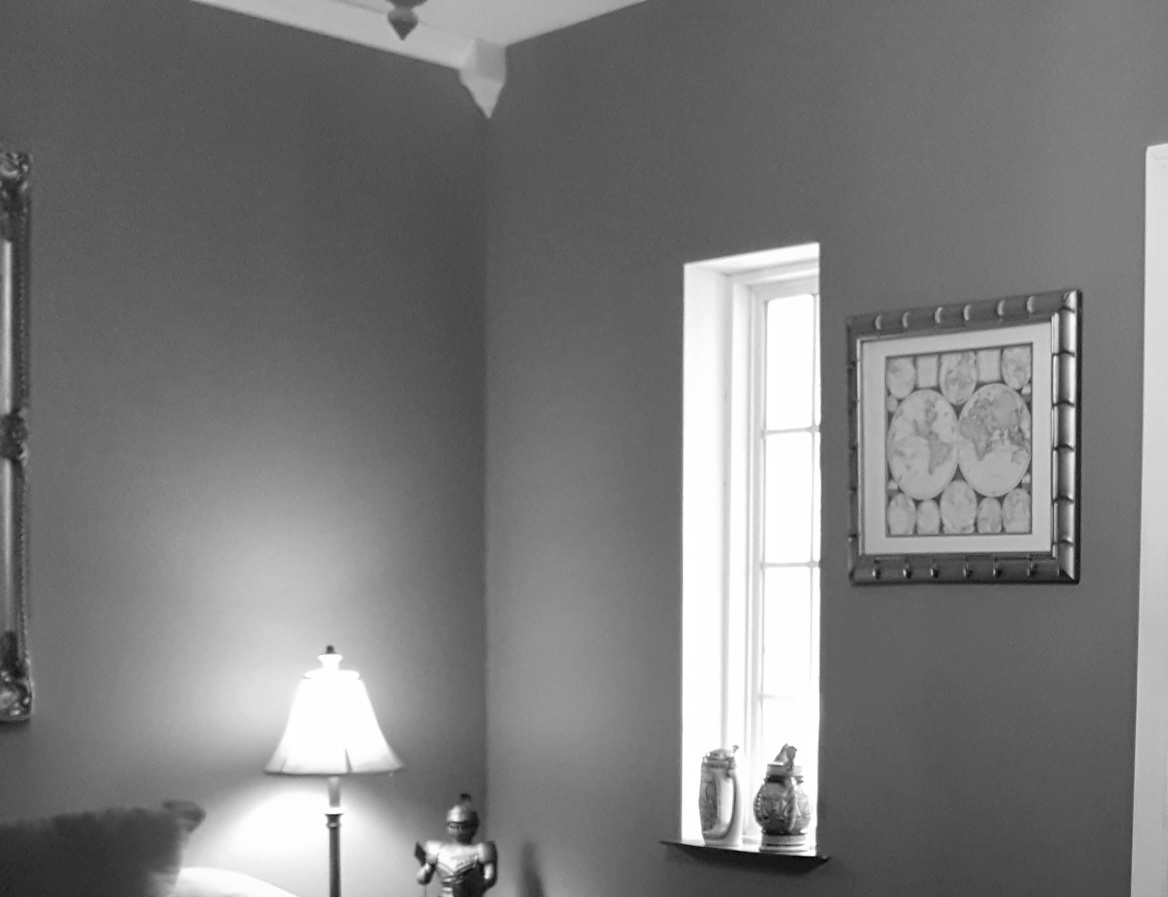

In [55]:
img = Image.open('./images/image.jpg')
img

In [65]:
img_arr = np.array(img)
img_arr.shape

(897, 1168, 3)

We convert this to a tensor to a format that PyTorch expects. Convutional layers expect the data to be of a $B \times C \times H \times W$ shaped tensor as input.

In [66]:
img_t = torch.Tensor(img_arr).permute(2, 0, 1).unsqueeze(0)

In [67]:
img_t.shape

torch.Size([1, 3, 897, 1168])

Now let's define the convolution neural network using the `pytorch.nn` module.

In [68]:
from torch import nn

In [93]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [94]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

How many parameters does this layer have?

In [95]:
sum([p.numel() for p in conv.parameters()])

448

In [96]:
np.product(conv.weight.shape) + conv.bias.shape[0]

448

In [97]:
output = conv(img_t)

In [99]:
import matplotlib.pyplot as plt

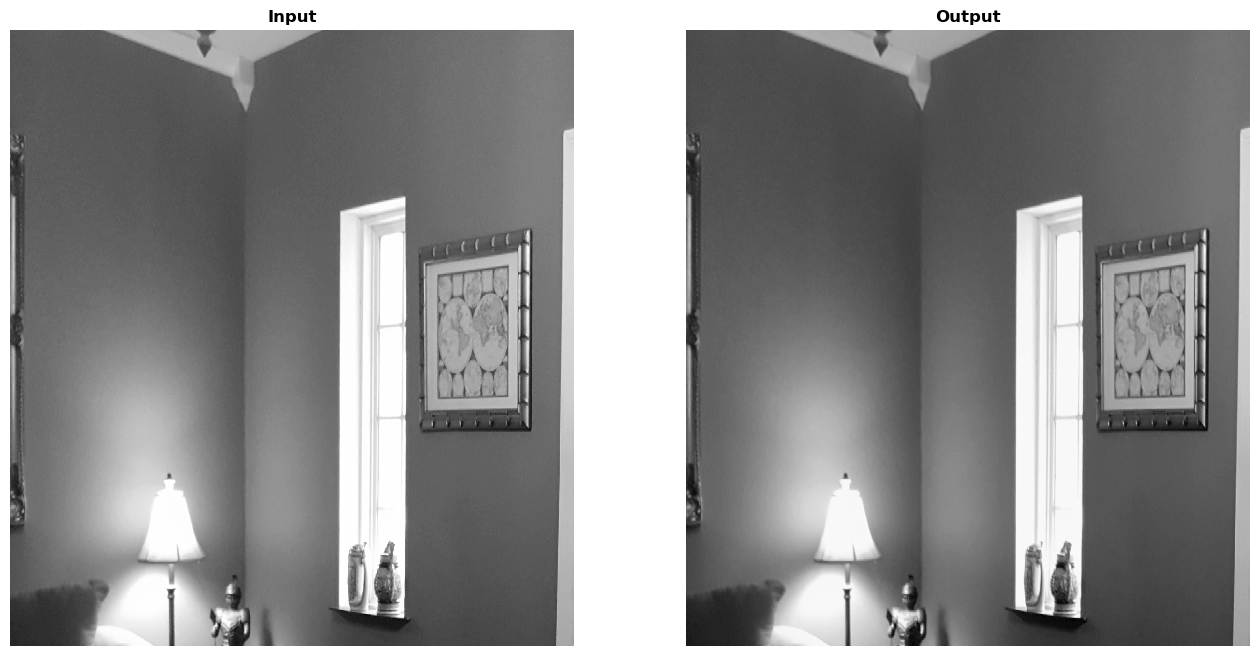

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(img_t[0, 0].detach(), cmap='gray', interpolation='nearest', aspect='auto')
axes[0].set_title("Input", fontsize=12, weight='bold')
axes[1].imshow(output[0, 0].detach(), cmap='gray', interpolation='nearest', aspect='auto')
axes[1].set_title("Output", fontsize=12, weight='bold')
for ax in axes:
    ax.axis('off')

In [140]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = (torch.tensor([[0, 1, 0],
                                    [1, -4, 1],
                                    [0, 1, 0]]))
#     conv.weight[:] = (torch.tensor([[0, -1, 0],
#                                     [-1, 5, -1],
#                                     [0, -1, 0]]))
#     conv.weight[:] = (torch.tensor([[-1, 0, 1],
#                                     [-1, 0, 1],
#                                     [-1, 0, 1]]))
#     conv.weight[:] = (torch.tensor([[-1, -1, -1],
#                                     [0, 0, 0],
#                                     [1, 1, 1]]))

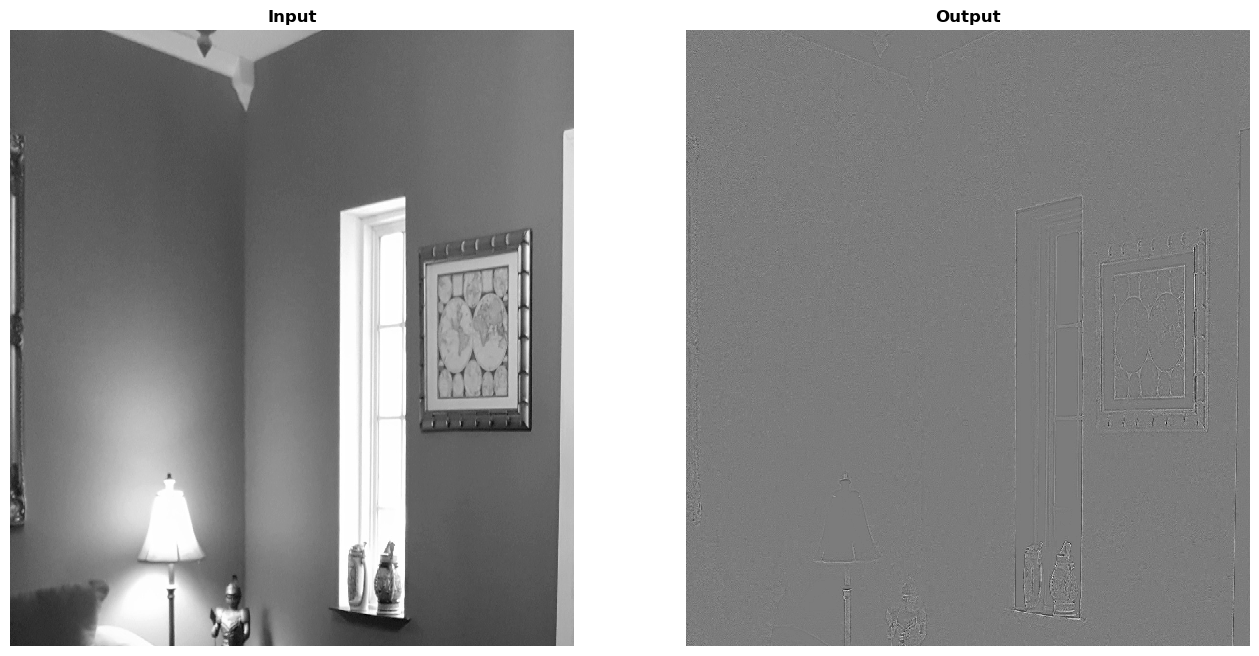

In [141]:
output = conv(img_t)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(img_t[0, 0].detach(), cmap='gray', interpolation='nearest', aspect='auto')
axes[0].set_title("Input", fontsize=12, weight='bold')
axes[1].imshow(output[0, 0].detach(), cmap='gray', interpolation='nearest', aspect='auto')
axes[1].set_title("Output", fontsize=12, weight='bold')
for ax in axes:
    ax.axis('off')

<div class='alert-info'>
    
**BREAK OUT ROOMS (15 minutes)**
    
Play around with the filters and share interesting findings if any from your team's experiments.

1. How do you create a blur filter?
2. How do you create a vertical edge detector?
3. How about a horizontal edge detector?
4. A diagonal edge detector?
5. What happens if we use a larger kernel size for our filters?
</div>

### Padding the boundary

One observation that we see during convolution is that the oiutput image is smaller than the input image.

In [142]:
img_t. shape, output.shape

(torch.Size([1, 3, 897, 1168]), torch.Size([1, 16, 895, 1166]))

This is because the convolutional kernel requires that there are neighbors in all directions. At the borders, for example the upper left corner, we only have pixels to the right and below of us. By default, PyTorch will slide the convolutional kernel within the picture. However, we can modify this behavior by specifying the `padding` argument.

In [144]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding='same')
output = conv(img_t)

In this case, PyTorch appends *ghost* pixels around the border giving them a value of 0. The net result is that the output now has the same size as the input image.

<img src='./images/padding.png' width=650/>

In [146]:
img_t. shape, output.shape

(torch.Size([1, 3, 897, 1168]), torch.Size([1, 1, 897, 1168]))

There are two main reasons for using padding. First, doing so helps us separate the matters of convoultion and changing image sizes. Second, when we consider more elaborate architectures, such as skip connections for residual networks (ResNet) or U-Nets, we want the tensors before and after a few convolutions to be of compatible size (so that we can add them or take differences between them).

The most commonly used padding mode in convolutional neural networks is same padding. One of its advantages over the other padding modes is that same padding preserves the height and width of the input images or tensors, which makes designing a network architecture more convenient.  

One big disadvantage of the valid padding versus full and same padding, for example, is that the volume of the tensors would decrease substantially in neural networks with many layers, which can be detrimental to the network performance. 

In practice, it is recommended that you preserve the spatial size using same padding for the convolutional layers and  decrease the spatial size via pooling layers instead. As for the full padding, its size results in an output larger than the input size. Full padding is usually used in signal processing applications where it is important to minimize  boundary effects. **However, in deep learning context, boundary effect is not usually an issue**, so we rarely see full padding.

## Downsampling using pooling operations

We've done well and good being able to create an architecture that considers the locality between pixels and is translationally invariant. However, we are forgetting the bigger picture. How do we know that the structure in our images are 3 pixels or 5 pixels wide? How will our networks learn and see patterns on a larger scope?

We can do this by performing downsampling. Which in principle we can perform in several ways:

1. Average pooling - take the average of the input neighbor pixels then produce the average value of all the pixels as the output.
2. Max pooling - instead of taking the average, take the maximum value of the neighboring pixels.
3. Perform a strided convolutions, where only every Nth pixel is calculated.

<img src='./images/max-pooling.png' width=650/>

The max pooling keeps the highest value in the neighborhood and ensures that surviving features have the strongest signal at the expense of weaker response signals.

## Putting everything together

By combining convolutions and downsampling, it helps us recognize larger structures. The first set of kernels operates on small neighborhoods, i.e. low-level features, while the second set of kernels (downsampling) operates on wider neighborhoods, producing features that are compositions of the previous features.

We can further elaborate on this by identifying the *receptive field* of each value in our output vector. The receptive field is the area of an image that is involved in the calculation of the layer.

<img src='./images/receptive-field.png' width=850>

The given output neuron of the 3 x 3-conv, 2 x 2 max-pool, and 3 x 3 conv has a receptive field of 8 x 8.

The mechanism of creating alternating convolutions and downsampling provides our network the ability to see into very complex scenes and learn important concepts in our image. Of course, the learning process by which our network obtains the correct weights will be done through gradient descent updating them individually in order to optimize for the loss.

<img src='./images/cat_CNN.png' width=650>